In [4]:
! pip install datasets

In [28]:
import pprint
from datasets import load_dataset, Dataset, concatenate_datasets

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

import json
import pprint
import pprint
# Import weights and biases
import wandb
# Import kaggle secrets
from google.colab import userdata

# Load dataset

In [35]:
with open('train_dataset.json', 'r') as f:
    train_dataset = json.load(f)

# Load test_dataset
with open('test_dataset.json', 'r') as f:
    test_dataset = json.load(f)

multiple_choice_testset = test_dataset['multiple_choice']
multiple_choice_trainset = train_dataset['multiple_choice']

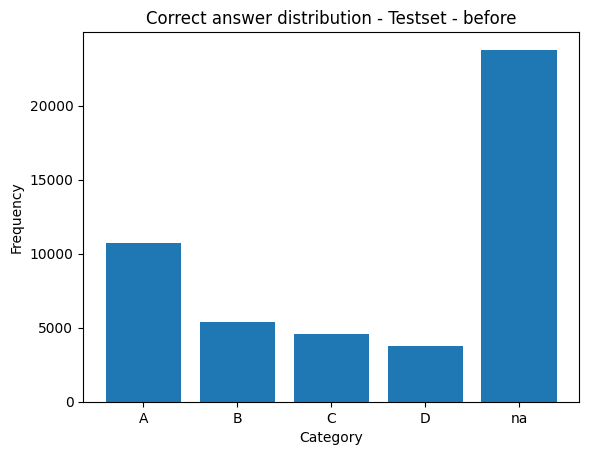

In [51]:
# Step 1: Extract 'age' values
ages = [entry['correct_answer'] for entry in multiple_choice_testset if entry['correct_answer'] is not None]

nones = ["na" for entry in multiple_choice_testset if entry['correct_answer'] is None]

import matplotlib.pyplot as plt
from collections import Counter

# Step 1: Count frequencies
counts = Counter(ages + nones)

# Step 2: Sort alphabetically
sorted_items = sorted(counts.items())  # List of tuples (label, count)
labels, values = zip(*sorted_items)    # Separate into x and y

# Step 3: Plot as bar chart
plt.bar(labels, values)
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.title('Correct answer distribution - Testset - before')
plt.show()



# Load baseline model

In [6]:
model_id = "deepseek-ai/deepseek-llm-7b-base"  # or any other DeepSeek model
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id,
                                             device_map="auto",
                                             torch_dtype=torch.float16)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/792 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.61M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

In [7]:
# Define a system prompt under prompt_style
prompt_style = """
"{_question_var_}"

### Answer:
"""

In [ ]:
def build_prompt(question: str):
  return prompt_style.replace("{_question_var_}", question)

pprint.pp(build_prompt(question))

('\n'
 '"A 23-year-old pregnant woman at 22 weeks gestation presents with burning '
 'upon urination. She states it started 1 day ago and has been worsening '
 'despite drinking more water and taking cranberry extract. She otherwise '
 'feels well and is followed by a doctor for her pregnancy. Her temperature is '
 '97.7°F (36.5°C), blood pressure is 122/77 mmHg, pulse is 80/min, '
 'respirations are 19/min, and oxygen saturation is 98% on room air. Physical '
 'exam is notable for an absence of costovertebral angle tenderness and a '
 'gravid uterus. Which of the following is the best treatment for this '
 'patient? Options: \n'
 ' A. Ampicillin\n'
 ' B. Ceftriaxone\n'
 ' C. Ciprofloxacin\n'
 ' D. Doxycycline\n'
 ' E. Nitrofurantoin"\n'
 '\n'
 '### Answer:\n')


In [ ]:
from transformers import pipeline

pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
response = pipe(build_prompt(question))

Device set to use cuda:0


In [ ]:
pprint.pp(response)

[{'generated_text': '\n'
                    '### Instruction:\n'
                    '"A 23-year-old pregnant woman at 22 weeks gestation '
                    'presents with burning upon urination. She states it '
                    'started 1 day ago and has been worsening despite drinking '
                    'more water and taking cranberry extract. She otherwise '
                    'feels well and is followed by a doctor for her pregnancy. '
                    'Her temperature is 97.7°F (36.5°C), blood pressure is '
                    '122/77 mmHg, pulse is 80/min, respirations are 19/min, '
                    'and oxygen saturation is 98% on room air. Physical exam '
                    'is notable for an absence of costovertebral angle '
                    'tenderness and a gravid uterus. Which of the following is '
                    'the best treatment for this patient? Options: \n'
                    ' A. Ampicillin\n'
                    ' B. Ceftriaxone\n'
      

In [ ]:
predictions = []

for i in range(50):
  options = 'A. ' + transformed_MC1_data[i].get('options').get('A') + ' B. ' + transformed_MC1_data[i].get('options').get('B') + ' C. ' + transformed_MC1_data[i].get('options').get('C') + ' D. ' + transformed_MC1_data[i].get('options').get('D') + ' E. ' + transformed_MC1_data[i].get('options').get('E')

  question = transformed_MC1_data[i].get('question') + ' Options: ' + options

  pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
  response = pipe(build_prompt(question))

  predictions.append(response)


Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0


In [ ]:
import re
predicted_answer = []
for sample in predictions:
  match = re.search(r'### Answer:\s*\n*([A-E])\.', sample[0].get('generated_text'))
  if match:
      answer = match.group(1)
      predicted_answer.append({"predicted_answer": answer})
  else:
      predicted_answer.append({"predicted_answer": "na"})


In [ ]:
correct_opt = [{"correct_answer": sample.get('correct_answer')} for sample in transformed_MC1_data[:50]]
combination = list(zip(predictions, predicted_answer, correct_opt))

In [ ]:
pprint.pp(combination)

[([{'generated_text': '\n'
                      '"A 23-year-old pregnant woman at 22 weeks gestation '
                      'presents with burning upon urination. She states it '
                      'started 1 day ago and has been worsening despite '
                      'drinking more water and taking cranberry extract. She '
                      'otherwise feels well and is followed by a doctor for '
                      'her pregnancy. Her temperature is 97.7°F (36.5°C), '
                      'blood pressure is 122/77 mmHg, pulse is 80/min, '
                      'respirations are 19/min, and oxygen saturation is 98% '
                      'on room air. Physical exam is notable for an absence of '
                      'costovertebral angle tenderness and a gravid uterus. '
                      'Which of the following is the best treatment for this '
                      'patient? Options: A. Ampicillin B. Ceftriaxone C. '
                      'Ciprofloxacin D. Doxycyc

# Build confusion matrix

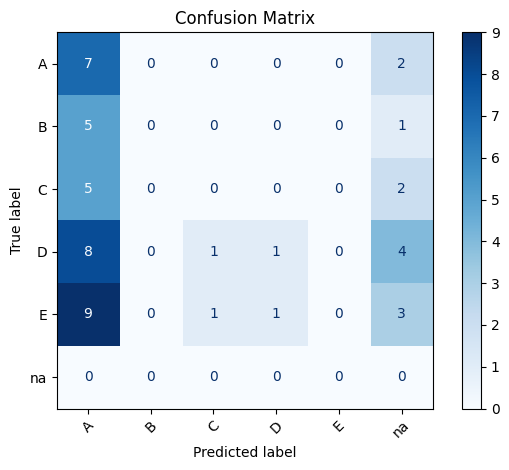

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Extract predicted and correct answers
y_pred = [entry[1]['predicted_answer'] for entry in combination]
y_true = [entry[2]['correct_answer'] for entry in combination]

# Generate confusion matrix
labels = sorted(list(set(y_true + y_pred)))  # Get all possible classes
cm = confusion_matrix(y_true, y_pred, labels=labels)

# Display the matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
